In [1]:
import torch
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
import pickle
from logger import Logger

In [2]:
# Parameters
image_size = 64
label_dim = 2
G_input_dim = 100
G_output_dim = 3
D_input_dim = 3
D_output_dim = 1
num_filters = [1024, 512, 256, 128]

learning_rate = 0.0002
betas = (0.5, 0.999)
batch_size = 128
num_epochs = 20

data_dir = '/scratch/ns4767/resized/'
save_dir = 'results_64/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [3]:
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

celebA_data = dsets.ImageFolder(data_dir, transform=transform)
celebA_data.imgs.sort()

data_loader = torch.utils.data.DataLoader(dataset=celebA_data,
                                          batch_size=batch_size,
                                          shuffle=False)

In [4]:
# For logger
def to_np(x):
    return x.data.cpu().numpy()


def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)


# De-normalization
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [5]:
# Generator model
class Generator(torch.nn.Module):
    def __init__(self, input_dim, label_dim, num_filters, output_dim):
        super(Generator, self).__init__()

        # Hidden layers
        self.hidden_layer1 = torch.nn.Sequential()
        self.hidden_layer2 = torch.nn.Sequential()
        self.hidden_layer = torch.nn.Sequential()
        for i in range(len(num_filters)):
            # Deconvolutional layer
            if i == 0:
                # For input
                input_deconv = torch.nn.ConvTranspose2d(input_dim, int(num_filters[i]/2), kernel_size=4, stride=1, padding=0)
                self.hidden_layer1.add_module('input_deconv', input_deconv)

                # Initializer
                torch.nn.init.normal_(input_deconv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant_(input_deconv.bias, 0.0)

                # Batch normalization
                self.hidden_layer1.add_module('input_bn', torch.nn.BatchNorm2d(int(num_filters[i]/2)))

                # Activation
                self.hidden_layer1.add_module('input_act', torch.nn.ReLU())

                # For label
                label_deconv = torch.nn.ConvTranspose2d(label_dim, int(num_filters[i]/2), kernel_size=4, stride=1, padding=0)
                self.hidden_layer2.add_module('label_deconv', label_deconv)

                # Initializer
                torch.nn.init.normal_(label_deconv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant_(label_deconv.bias, 0.0)

                # Batch normalization
                self.hidden_layer2.add_module('label_bn', torch.nn.BatchNorm2d(int(num_filters[i]/2)))

                # Activation
                self.hidden_layer2.add_module('label_act', torch.nn.ReLU())
            else:
                deconv = torch.nn.ConvTranspose2d(num_filters[i-1], num_filters[i], kernel_size=4, stride=2, padding=1)

                deconv_name = 'deconv' + str(i + 1)
                self.hidden_layer.add_module(deconv_name, deconv)

                # Initializer
                torch.nn.init.normal_(deconv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant_(deconv.bias, 0.0)

                # Batch normalization
                bn_name = 'bn' + str(i + 1)
                self.hidden_layer.add_module(bn_name, torch.nn.BatchNorm2d(num_filters[i]))

                # Activation
                act_name = 'act' + str(i + 1)
                self.hidden_layer.add_module(act_name, torch.nn.ReLU())

        # Output layer
        self.output_layer = torch.nn.Sequential()
        # Deconvolutional layer
        out = torch.nn.ConvTranspose2d(num_filters[i], output_dim, kernel_size=4, stride=2, padding=1)
        self.output_layer.add_module('out', out)
        # Initializer
        torch.nn.init.normal_(out.weight, mean=0.0, std=0.02)
        torch.nn.init.constant_(out.bias, 0.0)
        # Activation
        self.output_layer.add_module('act', torch.nn.Tanh())

    def forward(self, z, c):
        h1 = self.hidden_layer1(z)
        h2 = self.hidden_layer2(c)
        x = torch.cat([h1, h2], 1)
        h = self.hidden_layer(x)
        out = self.output_layer(h)
        return out

In [6]:
# Discriminator model
class Discriminator(torch.nn.Module):
    def __init__(self, input_dim, label_dim, num_filters, output_dim):
        super(Discriminator, self).__init__()

        self.hidden_layer1 = torch.nn.Sequential()
        self.hidden_layer2 = torch.nn.Sequential()
        self.hidden_layer = torch.nn.Sequential()
        for i in range(len(num_filters)):
            # Convolutional layer
            if i == 0:
                # For input
                input_conv = torch.nn.Conv2d(input_dim, int(num_filters[i]/2), kernel_size=4, stride=2, padding=1)
                self.hidden_layer1.add_module('input_conv', input_conv)

                # Initializer
                torch.nn.init.normal_(input_conv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant_(input_conv.bias, 0.0)

                # Activation
                self.hidden_layer1.add_module('input_act', torch.nn.LeakyReLU(0.2))

                # For label
                label_conv = torch.nn.Conv2d(label_dim, int(num_filters[i]/2), kernel_size=4, stride=2, padding=1)
                self.hidden_layer2.add_module('label_conv', label_conv)

                # Initializer
                torch.nn.init.normal_(label_conv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant_(label_conv.bias, 0.0)

                # Activation
                self.hidden_layer2.add_module('label_act', torch.nn.LeakyReLU(0.2))
            else:
                conv = torch.nn.Conv2d(num_filters[i-1], num_filters[i], kernel_size=4, stride=2, padding=1)

                conv_name = 'conv' + str(i + 1)
                self.hidden_layer.add_module(conv_name, conv)

                # Initializer
                torch.nn.init.normal_(conv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant_(conv.bias, 0.0)

                # Batch normalization
                bn_name = 'bn' + str(i + 1)
                self.hidden_layer.add_module(bn_name, torch.nn.BatchNorm2d(num_filters[i]))

                # Activation
                act_name = 'act' + str(i + 1)
                self.hidden_layer.add_module(act_name, torch.nn.LeakyReLU(0.2))

        # Output layer
        self.output_layer = torch.nn.Sequential()
        # Convolutional layer
        out = torch.nn.Conv2d(num_filters[i], output_dim, kernel_size=4, stride=1, padding=0)
        self.output_layer.add_module('out', out)
        # Initializer
        torch.nn.init.normal_(out.weight, mean=0.0, std=0.02)
        torch.nn.init.constant_(out.bias, 0.0)
        # Activation
        self.output_layer.add_module('act', torch.nn.Sigmoid())

    def forward(self, z, c):
        h1 = self.hidden_layer1(z)
        h2 = self.hidden_layer2(c)
        x = torch.cat([h1, h2], 1)
        h = self.hidden_layer(x)
        out = self.output_layer(h)
        return out


In [7]:
# Plot losses
def plot_loss(d_losses, g_losses, num_epoch, save=False, save_dir='cDCGAN_results/', show=True):
    fig, ax = plt.subplots()
    ax.set_xlim(0, num_epochs)
    ax.set_ylim(0, max(np.max(g_losses), np.max(d_losses))*1.1)
    plt.xlabel('Epoch {0}'.format(num_epoch + 1))
    plt.ylabel('Loss values')
    plt.plot(d_losses, label='Discriminator')
    plt.plot(g_losses, label='Generator')
    plt.legend()

    # save figure
    if save:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        save_fn = save_dir + 'cDCGAN_losses_epoch_{:d}'.format(num_epoch + 1) + '.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()

In [8]:
def plot_result(generator, noise, label, num_epoch, save=False, save_dir='cDCGAN_results/', show=True, fig_size=(5, 5)):
    generator.eval()

    noise = Variable(noise.cuda())
    label = Variable(label.cuda())
    gen_image = generator(noise, label)
    gen_image = denorm(gen_image)

    generator.train()

    n_rows = np.sqrt(noise.size()[0]).astype(np.int32)
    n_cols = np.sqrt(noise.size()[0]).astype(np.int32)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=fig_size)
    for ax, img in zip(axes.flatten(), gen_image):
        ax.axis('off')
        ax.set_adjustable('box')
        # Scale to 0-255
        img = (((img - img.min()) * 255) / (img.max() - img.min())).cpu().data.numpy().transpose(1, 2, 0).astype(
            np.uint8)
        # ax.imshow(img.cpu().data.view(image_size, image_size, 3).numpy(), cmap=None, aspect='equal')
        ax.imshow(img, cmap=None, aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)
    title = 'Epoch {0}'.format(num_epoch + 1)
    fig.text(0.5, 0.04, title, ha='center')

    # save figure
    if save:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        save_fn = save_dir + 'cDCGAN_epoch_{:d}'.format(num_epoch+1) + '.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()


In [9]:
def plot_morp_result(generator, save=False, save_dir='cDCGAN_results/', show=True, fig_size=(10, 10)):
    source_z_ = torch.randn(10, G_input_dim)
    z_ = torch.zeros(10*10, G_input_dim)
    for i in range(5):
        for j in range(10):
            z_[i * 20 + j] = (source_z_[i * 2 + 1] - source_z_[i * 2]) / 9 * (j + 1) + source_z_[i * 2]

    for i in range(5):
        z_[i * 20 + 10:i * 20 + 20] = z_[i * 20:i * 20 + 10]

    y_ = torch.cat([torch.zeros(10, 1), torch.ones(10, 1)], 0).type(torch.LongTensor).squeeze()
    y_ = torch.cat([y_, y_, y_, y_, y_], 0)
    y_label_ = onehot[y_]
    noise = z_.view(-1, G_input_dim, 1, 1)
    label = y_label_.view(-1, label_dim, 1, 1)

    generator.eval()

    noise = Variable(noise.cuda())
    label = Variable(label.cuda())
    gen_image = generator(noise, label)
    gen_image = denorm(gen_image)

    generator.train()

    n_rows = np.sqrt(noise.size()[0]).astype(np.int32)
    n_cols = np.sqrt(noise.size()[0]).astype(np.int32)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=fig_size)
    for ax, img in zip(axes.flatten(), gen_image):
        ax.axis('off')
        ax.set_adjustable('box')
        # Scale to 0-255
        img = (((img - img.min()) * 255) / (img.max() - img.min())).cpu().data.numpy().transpose(1, 2, 0).astype(
            np.uint8)
        ax.imshow(img, cmap=None, aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)

    # save figure
    if save:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        save_fn = save_dir + 'cDCGAN_noise_morp.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()

In [10]:
# Models
G = Generator(G_input_dim, label_dim, num_filters, G_output_dim)
D = Discriminator(D_input_dim, label_dim, num_filters[::-1], D_output_dim)
G.cuda()
D.cuda()
print(G)
print(D)

Generator(
  (hidden_layer1): Sequential(
    (input_deconv): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (input_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (input_act): ReLU()
  )
  (hidden_layer2): Sequential(
    (label_deconv): ConvTranspose2d(2, 512, kernel_size=(4, 4), stride=(1, 1))
    (label_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (label_act): ReLU()
  )
  (hidden_layer): Sequential(
    (deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU()
    (deconv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act3): ReLU()
    (deconv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padd

In [11]:
# Set the logger
D_log_dir = save_dir + 'D_logs'
G_log_dir = save_dir + 'G_logs'
if not os.path.exists(D_log_dir):
    os.mkdir(D_log_dir)
D_logger = Logger(D_log_dir)

if not os.path.exists(G_log_dir):
    os.mkdir(G_log_dir)
G_logger = Logger(G_log_dir)

In [12]:
# Loss function
criterion = torch.nn.BCELoss()

# Optimizers
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate, betas=betas)
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate, betas=betas)

In [13]:
with open('label.pkl', 'rb') as fp:
    label = pickle.load(fp)
label = torch.LongTensor(label).squeeze()

In [14]:
# Label preprocess
onehot = torch.zeros(label_dim, label_dim)
onehot = onehot.scatter_(1, torch.LongTensor([0, 1]).view(label_dim, 1), 1).view(label_dim, label_dim, 1, 1)
fill = torch.zeros([label_dim, label_dim, image_size, image_size])
for i in range(label_dim):
    fill[i, i, :, :] = 1

In [15]:
# fixed noise & label
temp_noise0_ = torch.randn(4, G_input_dim)
temp_noise0_ = torch.cat([temp_noise0_, temp_noise0_], 0)
temp_noise1_ = torch.randn(4, G_input_dim)
temp_noise1_ = torch.cat([temp_noise1_, temp_noise1_], 0)

fixed_noise = torch.cat([temp_noise0_, temp_noise1_], 0)
fixed_label = torch.cat([torch.zeros(4), torch.ones(4), torch.zeros(4), torch.ones(4)], 0).type(torch.LongTensor).squeeze()

fixed_noise = fixed_noise.view(-1, G_input_dim, 1, 1)
fixed_label = onehot[fixed_label]

Epoch [1/20], Step [1/259], D_loss: 1.8242, G_loss: 6.4469
Epoch [1/20], Step [2/259], D_loss: 32.3013, G_loss: 10.0010
Epoch [1/20], Step [3/259], D_loss: 7.9369, G_loss: 17.6002
Epoch [1/20], Step [4/259], D_loss: 0.6876, G_loss: 17.7752
Epoch [1/20], Step [5/259], D_loss: 3.9859, G_loss: 19.8535
Epoch [1/20], Step [6/259], D_loss: 0.2924, G_loss: 15.4865
Epoch [1/20], Step [7/259], D_loss: 3.0609, G_loss: 20.0976
Epoch [1/20], Step [8/259], D_loss: 0.3487, G_loss: 21.4348
Epoch [1/20], Step [9/259], D_loss: 0.2422, G_loss: 19.5883
Epoch [1/20], Step [10/259], D_loss: 0.3174, G_loss: 19.3445
Epoch [1/20], Step [11/259], D_loss: 0.1830, G_loss: 17.2411
Epoch [1/20], Step [12/259], D_loss: 0.1155, G_loss: 18.8396
Epoch [1/20], Step [13/259], D_loss: 0.1479, G_loss: 20.1638
Epoch [1/20], Step [14/259], D_loss: 0.0451, G_loss: 16.3294
Epoch [1/20], Step [15/259], D_loss: 0.0517, G_loss: 13.2594
Epoch [1/20], Step [16/259], D_loss: 0.0040, G_loss: 9.1814
Epoch [1/20], Step [17/259], D_los

Epoch [1/20], Step [136/259], D_loss: 0.0034, G_loss: 8.0803
Epoch [1/20], Step [137/259], D_loss: 0.0116, G_loss: 7.9547
Epoch [1/20], Step [138/259], D_loss: 0.0003, G_loss: 8.3551
Epoch [1/20], Step [139/259], D_loss: 0.0003, G_loss: 8.2930
Epoch [1/20], Step [140/259], D_loss: 0.0003, G_loss: 8.2976
Epoch [1/20], Step [141/259], D_loss: 0.0003, G_loss: 8.0696
Epoch [1/20], Step [142/259], D_loss: 0.0005, G_loss: 8.1243
Epoch [1/20], Step [143/259], D_loss: 0.0014, G_loss: 8.1055
Epoch [1/20], Step [144/259], D_loss: 0.0009, G_loss: 7.4033
Epoch [1/20], Step [145/259], D_loss: 0.0007, G_loss: 8.0283
Epoch [1/20], Step [146/259], D_loss: 0.0005, G_loss: 7.9603
Epoch [1/20], Step [147/259], D_loss: 0.0010, G_loss: 7.9465
Epoch [1/20], Step [148/259], D_loss: 0.0006, G_loss: 7.8593
Epoch [1/20], Step [149/259], D_loss: 0.0005, G_loss: 7.7463
Epoch [1/20], Step [150/259], D_loss: 0.0019, G_loss: 7.6128
Epoch [1/20], Step [151/259], D_loss: 0.0009, G_loss: 7.8173
Epoch [1/20], Step [152/

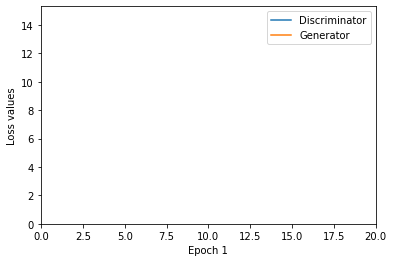

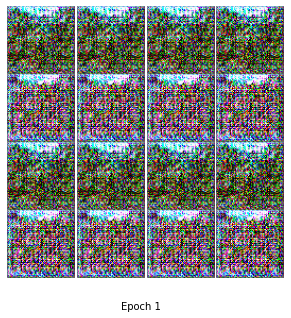

Epoch [2/20], Step [1/259], D_loss: 2.4147, G_loss: 3.6107
Epoch [2/20], Step [2/259], D_loss: 0.1371, G_loss: 6.2454
Epoch [2/20], Step [3/259], D_loss: 0.0099, G_loss: 7.4533
Epoch [2/20], Step [4/259], D_loss: 0.0090, G_loss: 8.0688
Epoch [2/20], Step [5/259], D_loss: 0.0532, G_loss: 9.8384
Epoch [2/20], Step [6/259], D_loss: 0.0013, G_loss: 10.4572
Epoch [2/20], Step [7/259], D_loss: 0.0002, G_loss: 10.9256
Epoch [2/20], Step [8/259], D_loss: 0.0000, G_loss: 10.9968
Epoch [2/20], Step [9/259], D_loss: 0.0000, G_loss: 10.4962
Epoch [2/20], Step [10/259], D_loss: 0.0001, G_loss: 10.9381
Epoch [2/20], Step [11/259], D_loss: 0.0001, G_loss: 10.8938
Epoch [2/20], Step [12/259], D_loss: 0.0000, G_loss: 10.5620
Epoch [2/20], Step [13/259], D_loss: 0.0009, G_loss: 10.7411
Epoch [2/20], Step [14/259], D_loss: 0.0001, G_loss: 10.5357
Epoch [2/20], Step [15/259], D_loss: 0.0001, G_loss: 10.5204
Epoch [2/20], Step [16/259], D_loss: 0.0000, G_loss: 10.2746
Epoch [2/20], Step [17/259], D_loss: 0

Epoch [2/20], Step [137/259], D_loss: 0.0004, G_loss: 8.1273
Epoch [2/20], Step [138/259], D_loss: 0.0005, G_loss: 8.0499
Epoch [2/20], Step [139/259], D_loss: 0.0017, G_loss: 8.1572
Epoch [2/20], Step [140/259], D_loss: 0.0004, G_loss: 8.2227
Epoch [2/20], Step [141/259], D_loss: 0.0003, G_loss: 8.2102
Epoch [2/20], Step [142/259], D_loss: 0.0003, G_loss: 8.2098
Epoch [2/20], Step [143/259], D_loss: 0.0010, G_loss: 8.0889
Epoch [2/20], Step [144/259], D_loss: 0.0007, G_loss: 8.2307
Epoch [2/20], Step [145/259], D_loss: 0.0009, G_loss: 8.2278
Epoch [2/20], Step [146/259], D_loss: 0.0003, G_loss: 8.1539
Epoch [2/20], Step [147/259], D_loss: 0.0003, G_loss: 8.1492
Epoch [2/20], Step [148/259], D_loss: 0.0017, G_loss: 8.2965
Epoch [2/20], Step [149/259], D_loss: 0.0003, G_loss: 8.2732
Epoch [2/20], Step [150/259], D_loss: 0.0005, G_loss: 8.2193
Epoch [2/20], Step [151/259], D_loss: 0.0003, G_loss: 8.2971
Epoch [2/20], Step [152/259], D_loss: 0.0003, G_loss: 8.2827
Epoch [2/20], Step [153/

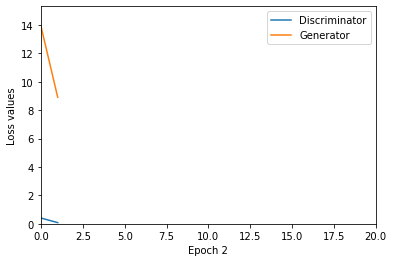

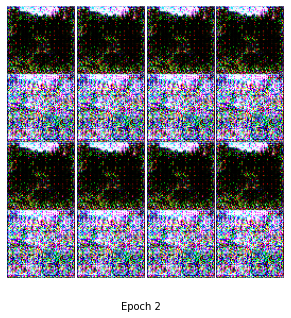

Epoch [3/20], Step [1/259], D_loss: 0.0001, G_loss: 9.5636
Epoch [3/20], Step [2/259], D_loss: 0.0008, G_loss: 9.4462
Epoch [3/20], Step [3/259], D_loss: 0.0004, G_loss: 9.2610
Epoch [3/20], Step [4/259], D_loss: 0.0001, G_loss: 9.5146
Epoch [3/20], Step [5/259], D_loss: 0.0001, G_loss: 9.4551
Epoch [3/20], Step [6/259], D_loss: 0.0003, G_loss: 9.5620
Epoch [3/20], Step [7/259], D_loss: 0.0001, G_loss: 9.6308
Epoch [3/20], Step [8/259], D_loss: 0.0002, G_loss: 9.4517
Epoch [3/20], Step [9/259], D_loss: 0.0003, G_loss: 9.6302
Epoch [3/20], Step [10/259], D_loss: 0.0001, G_loss: 9.6333
Epoch [3/20], Step [11/259], D_loss: 0.0015, G_loss: 9.5501
Epoch [3/20], Step [12/259], D_loss: 0.0004, G_loss: 9.6977
Epoch [3/20], Step [13/259], D_loss: 0.0001, G_loss: 9.7244
Epoch [3/20], Step [14/259], D_loss: 0.0001, G_loss: 9.7105
Epoch [3/20], Step [15/259], D_loss: 0.0001, G_loss: 9.7260
Epoch [3/20], Step [16/259], D_loss: 0.0001, G_loss: 9.5735
Epoch [3/20], Step [17/259], D_loss: 0.0002, G_lo

Epoch [3/20], Step [137/259], D_loss: 0.0005, G_loss: 9.6430
Epoch [3/20], Step [138/259], D_loss: 0.0001, G_loss: 9.6403
Epoch [3/20], Step [139/259], D_loss: 0.0001, G_loss: 9.7387
Epoch [3/20], Step [140/259], D_loss: 0.0001, G_loss: 9.7427
Epoch [3/20], Step [141/259], D_loss: 0.0001, G_loss: 9.5648
Epoch [3/20], Step [142/259], D_loss: 0.0001, G_loss: 9.7353
Epoch [3/20], Step [143/259], D_loss: 0.0001, G_loss: 9.6946
Epoch [3/20], Step [144/259], D_loss: 0.0001, G_loss: 9.6684
Epoch [3/20], Step [145/259], D_loss: 0.0002, G_loss: 9.7249
Epoch [3/20], Step [146/259], D_loss: 0.0001, G_loss: 9.6630
Epoch [3/20], Step [147/259], D_loss: 0.0001, G_loss: 9.7146
Epoch [3/20], Step [148/259], D_loss: 0.0001, G_loss: 9.3594
Epoch [3/20], Step [149/259], D_loss: 0.0002, G_loss: 9.7152
Epoch [3/20], Step [150/259], D_loss: 0.0001, G_loss: 9.6796
Epoch [3/20], Step [151/259], D_loss: 0.0001, G_loss: 9.6906
Epoch [3/20], Step [152/259], D_loss: 0.0001, G_loss: 9.6684
Epoch [3/20], Step [153/

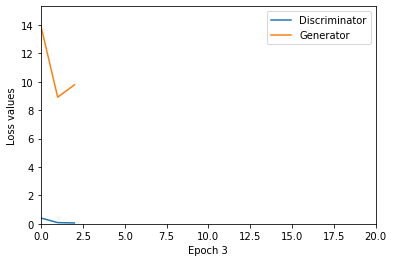

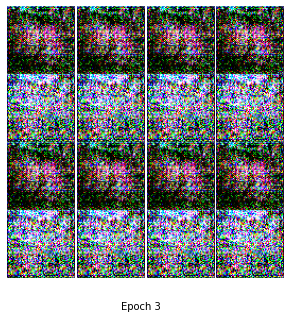

Epoch [4/20], Step [1/259], D_loss: 0.0002, G_loss: 9.8252
Epoch [4/20], Step [2/259], D_loss: 0.0001, G_loss: 9.8762
Epoch [4/20], Step [3/259], D_loss: 0.0001, G_loss: 9.8687
Epoch [4/20], Step [4/259], D_loss: 0.0001, G_loss: 9.7462
Epoch [4/20], Step [5/259], D_loss: 0.0001, G_loss: 9.8774
Epoch [4/20], Step [6/259], D_loss: 0.0001, G_loss: 9.8586
Epoch [4/20], Step [7/259], D_loss: 0.0001, G_loss: 9.8544
Epoch [4/20], Step [8/259], D_loss: 0.0001, G_loss: 9.8771
Epoch [4/20], Step [9/259], D_loss: 0.0001, G_loss: 9.8741
Epoch [4/20], Step [10/259], D_loss: 0.0001, G_loss: 9.8771
Epoch [4/20], Step [11/259], D_loss: 0.0001, G_loss: 9.8682
Epoch [4/20], Step [12/259], D_loss: 0.0001, G_loss: 9.8621
Epoch [4/20], Step [13/259], D_loss: 0.0001, G_loss: 9.7571
Epoch [4/20], Step [14/259], D_loss: 0.0001, G_loss: 9.8607
Epoch [4/20], Step [15/259], D_loss: 0.0001, G_loss: 9.4294
Epoch [4/20], Step [16/259], D_loss: 0.0001, G_loss: 9.8773
Epoch [4/20], Step [17/259], D_loss: 0.0001, G_lo

Epoch [4/20], Step [137/259], D_loss: 0.0000, G_loss: 13.9497
Epoch [4/20], Step [138/259], D_loss: 0.0000, G_loss: 14.4075
Epoch [4/20], Step [139/259], D_loss: 0.0000, G_loss: 14.2321
Epoch [4/20], Step [140/259], D_loss: 0.0000, G_loss: 14.3862
Epoch [4/20], Step [141/259], D_loss: 0.0000, G_loss: 14.3551
Epoch [4/20], Step [142/259], D_loss: 0.0000, G_loss: 13.8559
Epoch [4/20], Step [143/259], D_loss: 0.0000, G_loss: 14.2422
Epoch [4/20], Step [144/259], D_loss: 0.0000, G_loss: 14.1611
Epoch [4/20], Step [145/259], D_loss: 0.0000, G_loss: 13.9009
Epoch [4/20], Step [146/259], D_loss: 0.0000, G_loss: 13.9540
Epoch [4/20], Step [147/259], D_loss: 0.0000, G_loss: 14.2892
Epoch [4/20], Step [148/259], D_loss: 0.0000, G_loss: 14.3425
Epoch [4/20], Step [149/259], D_loss: 0.0000, G_loss: 14.2081
Epoch [4/20], Step [150/259], D_loss: 0.0000, G_loss: 14.2028
Epoch [4/20], Step [151/259], D_loss: 0.0000, G_loss: 13.8070
Epoch [4/20], Step [152/259], D_loss: 0.0000, G_loss: 14.3141
Epoch [4

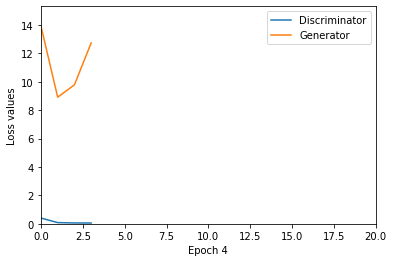

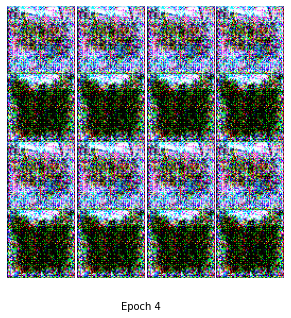

Epoch [5/20], Step [1/259], D_loss: 0.1497, G_loss: 13.3167
Epoch [5/20], Step [2/259], D_loss: 0.0001, G_loss: 12.8244
Epoch [5/20], Step [3/259], D_loss: 0.0004, G_loss: 12.5349
Epoch [5/20], Step [4/259], D_loss: 0.0006, G_loss: 12.2165
Epoch [5/20], Step [5/259], D_loss: 0.0522, G_loss: 12.2613
Epoch [5/20], Step [6/259], D_loss: 0.0001, G_loss: 11.4540
Epoch [5/20], Step [7/259], D_loss: 0.0003, G_loss: 11.9321
Epoch [5/20], Step [8/259], D_loss: 0.0002, G_loss: 11.3774
Epoch [5/20], Step [9/259], D_loss: 0.0005, G_loss: 11.8099
Epoch [5/20], Step [10/259], D_loss: 0.0002, G_loss: 11.7978
Epoch [5/20], Step [11/259], D_loss: 0.0004, G_loss: 11.7958
Epoch [5/20], Step [12/259], D_loss: 0.0016, G_loss: 11.5407
Epoch [5/20], Step [13/259], D_loss: 0.0001, G_loss: 11.5504
Epoch [5/20], Step [14/259], D_loss: 0.0002, G_loss: 11.6970
Epoch [5/20], Step [15/259], D_loss: 0.0003, G_loss: 11.6594
Epoch [5/20], Step [16/259], D_loss: 0.0001, G_loss: 11.2591
Epoch [5/20], Step [17/259], D_lo

Epoch [5/20], Step [135/259], D_loss: 0.0000, G_loss: 12.7804
Epoch [5/20], Step [136/259], D_loss: 0.0000, G_loss: 12.0000
Epoch [5/20], Step [137/259], D_loss: 0.0001, G_loss: 13.2470
Epoch [5/20], Step [138/259], D_loss: 0.0000, G_loss: 13.5405
Epoch [5/20], Step [139/259], D_loss: 0.0000, G_loss: 12.4043
Epoch [5/20], Step [140/259], D_loss: 0.0000, G_loss: 12.3994
Epoch [5/20], Step [141/259], D_loss: 0.0000, G_loss: 12.9100
Epoch [5/20], Step [142/259], D_loss: 0.0000, G_loss: 13.6081
Epoch [5/20], Step [143/259], D_loss: 0.0000, G_loss: 13.1666
Epoch [5/20], Step [144/259], D_loss: 0.0000, G_loss: 12.3852
Epoch [5/20], Step [145/259], D_loss: 0.0000, G_loss: 12.8187
Epoch [5/20], Step [146/259], D_loss: 0.0000, G_loss: 12.7349
Epoch [5/20], Step [147/259], D_loss: 0.0000, G_loss: 13.1519
Epoch [5/20], Step [148/259], D_loss: 0.0000, G_loss: 13.0247
Epoch [5/20], Step [149/259], D_loss: 0.0000, G_loss: 12.9528
Epoch [5/20], Step [150/259], D_loss: 0.0000, G_loss: 12.7208
Epoch [5

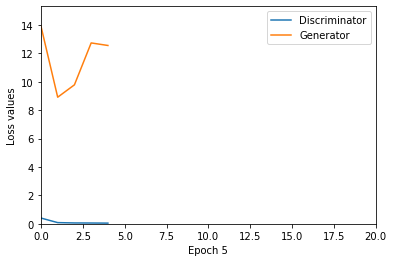

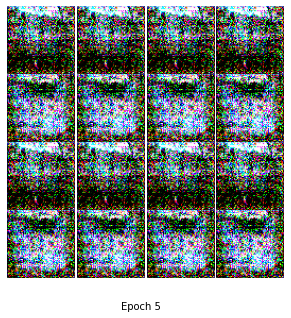

Epoch [6/20], Step [1/259], D_loss: 0.0001, G_loss: 12.8612
Epoch [6/20], Step [2/259], D_loss: 0.0000, G_loss: 13.2020
Epoch [6/20], Step [3/259], D_loss: 0.0000, G_loss: 12.5269
Epoch [6/20], Step [4/259], D_loss: 0.0000, G_loss: 12.6015
Epoch [6/20], Step [5/259], D_loss: 0.0001, G_loss: 12.6014
Epoch [6/20], Step [6/259], D_loss: 0.0001, G_loss: 12.6720
Epoch [6/20], Step [7/259], D_loss: 0.0001, G_loss: 13.2012
Epoch [6/20], Step [8/259], D_loss: 0.0000, G_loss: 12.6718
Epoch [6/20], Step [9/259], D_loss: 0.0000, G_loss: 12.1889
Epoch [6/20], Step [10/259], D_loss: 0.0000, G_loss: 13.1001
Epoch [6/20], Step [11/259], D_loss: 0.0000, G_loss: 13.0590
Epoch [6/20], Step [12/259], D_loss: 0.0000, G_loss: 12.3647
Epoch [6/20], Step [13/259], D_loss: 0.0000, G_loss: 13.1369
Epoch [6/20], Step [14/259], D_loss: 0.0000, G_loss: 13.0143
Epoch [6/20], Step [15/259], D_loss: 0.0001, G_loss: 12.6000
Epoch [6/20], Step [16/259], D_loss: 0.0001, G_loss: 12.8005
Epoch [6/20], Step [17/259], D_lo

Epoch [6/20], Step [135/259], D_loss: 0.0000, G_loss: 10.4515
Epoch [6/20], Step [136/259], D_loss: 0.0000, G_loss: 10.9877
Epoch [6/20], Step [137/259], D_loss: 0.0000, G_loss: 11.1294
Epoch [6/20], Step [138/259], D_loss: 0.0000, G_loss: 11.0852
Epoch [6/20], Step [139/259], D_loss: 0.0001, G_loss: 10.6808
Epoch [6/20], Step [140/259], D_loss: 0.0003, G_loss: 11.0854
Epoch [6/20], Step [141/259], D_loss: 0.0000, G_loss: 10.3692
Epoch [6/20], Step [142/259], D_loss: 0.0000, G_loss: 10.9879
Epoch [6/20], Step [143/259], D_loss: 0.0000, G_loss: 10.6811
Epoch [6/20], Step [144/259], D_loss: 0.0000, G_loss: 11.0853
Epoch [6/20], Step [145/259], D_loss: 0.0000, G_loss: 10.6808
Epoch [6/20], Step [146/259], D_loss: 0.0000, G_loss: 11.1294
Epoch [6/20], Step [147/259], D_loss: 0.0002, G_loss: 10.8152
Epoch [6/20], Step [148/259], D_loss: 0.0000, G_loss: 10.7501
Epoch [6/20], Step [149/259], D_loss: 0.0000, G_loss: 10.2832
Epoch [6/20], Step [150/259], D_loss: 0.0000, G_loss: 10.0992
Epoch [6

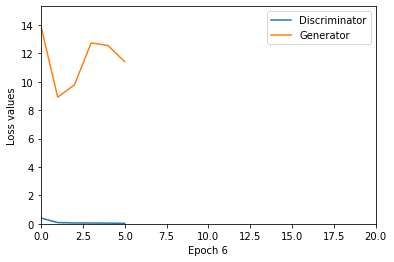

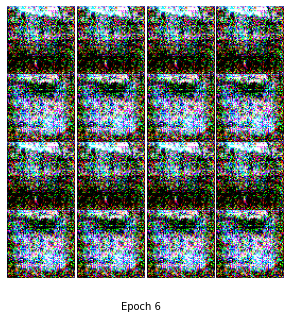

Epoch [7/20], Step [1/259], D_loss: 0.0000, G_loss: 10.8781
Epoch [7/20], Step [2/259], D_loss: 0.0000, G_loss: 10.8165
Epoch [7/20], Step [3/259], D_loss: 0.0000, G_loss: 10.7512
Epoch [7/20], Step [4/259], D_loss: 0.0000, G_loss: 10.8163
Epoch [7/20], Step [5/259], D_loss: 0.0000, G_loss: 11.1728
Epoch [7/20], Step [6/259], D_loss: 0.0000, G_loss: 10.7511
Epoch [7/20], Step [7/259], D_loss: 0.0000, G_loss: 10.9896
Epoch [7/20], Step [8/259], D_loss: 0.0002, G_loss: 10.9358
Epoch [7/20], Step [9/259], D_loss: 0.0002, G_loss: 10.8783
Epoch [7/20], Step [10/259], D_loss: 0.0000, G_loss: 10.8166
Epoch [7/20], Step [11/259], D_loss: 0.0000, G_loss: 11.2744
Epoch [7/20], Step [12/259], D_loss: 0.0000, G_loss: 10.7515
Epoch [7/20], Step [13/259], D_loss: 0.0000, G_loss: 10.8166
Epoch [7/20], Step [14/259], D_loss: 0.0000, G_loss: 10.2844
Epoch [7/20], Step [15/259], D_loss: 0.0000, G_loss: 10.9360
Epoch [7/20], Step [16/259], D_loss: 0.0000, G_loss: 11.1319
Epoch [7/20], Step [17/259], D_lo

Epoch [7/20], Step [136/259], D_loss: 0.0002, G_loss: 8.0664
Epoch [7/20], Step [137/259], D_loss: 0.0002, G_loss: 9.0992
Epoch [7/20], Step [138/259], D_loss: 0.0002, G_loss: 7.8786
Epoch [7/20], Step [139/259], D_loss: 0.0002, G_loss: 8.6885
Epoch [7/20], Step [140/259], D_loss: 0.0002, G_loss: 8.3265
Epoch [7/20], Step [141/259], D_loss: 0.0002, G_loss: 8.0683
Epoch [7/20], Step [142/259], D_loss: 0.0002, G_loss: 8.1586
Epoch [7/20], Step [143/259], D_loss: 0.0002, G_loss: 8.5550
Epoch [7/20], Step [144/259], D_loss: 0.0012, G_loss: 9.0646
Epoch [7/20], Step [145/259], D_loss: 0.0003, G_loss: 8.5580
Epoch [7/20], Step [146/259], D_loss: 0.0010, G_loss: 8.9768
Epoch [7/20], Step [147/259], D_loss: 0.0003, G_loss: 8.9782
Epoch [7/20], Step [148/259], D_loss: 0.0002, G_loss: 8.4137
Epoch [7/20], Step [149/259], D_loss: 0.0002, G_loss: 8.7607
Epoch [7/20], Step [150/259], D_loss: 0.0002, G_loss: 8.6986
Epoch [7/20], Step [151/259], D_loss: 0.0007, G_loss: 8.4159
Epoch [7/20], Step [152/

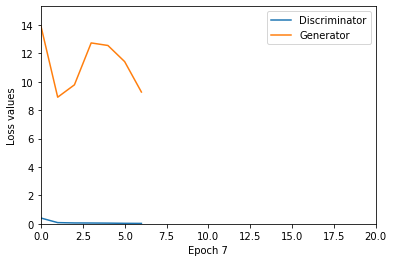

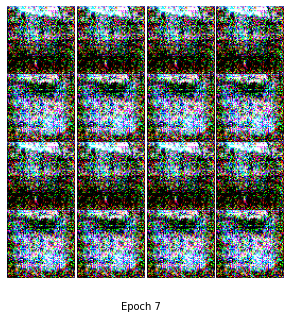

Epoch [8/20], Step [1/259], D_loss: 0.0006, G_loss: 8.9787
Epoch [8/20], Step [2/259], D_loss: 0.0006, G_loss: 9.2514
Epoch [8/20], Step [3/259], D_loss: 0.0010, G_loss: 8.1793
Epoch [8/20], Step [4/259], D_loss: 0.0001, G_loss: 8.9263
Epoch [8/20], Step [5/259], D_loss: 0.0002, G_loss: 9.0876
Epoch [8/20], Step [6/259], D_loss: 0.0002, G_loss: 8.1819
Epoch [8/20], Step [7/259], D_loss: 0.0002, G_loss: 8.5216
Epoch [8/20], Step [8/259], D_loss: 0.0005, G_loss: 8.5226
Epoch [8/20], Step [9/259], D_loss: 0.0002, G_loss: 8.9867
Epoch [8/20], Step [10/259], D_loss: 0.0004, G_loss: 8.6000
Epoch [8/20], Step [11/259], D_loss: 0.0002, G_loss: 8.8721
Epoch [8/20], Step [12/259], D_loss: 0.0002, G_loss: 9.3473
Epoch [8/20], Step [13/259], D_loss: 0.0010, G_loss: 8.6755
Epoch [8/20], Step [14/259], D_loss: 0.0002, G_loss: 8.8121
Epoch [8/20], Step [15/259], D_loss: 0.0001, G_loss: 8.9921
Epoch [8/20], Step [16/259], D_loss: 0.0002, G_loss: 8.5292
Epoch [8/20], Step [17/259], D_loss: 0.0003, G_lo

Epoch [8/20], Step [138/259], D_loss: 0.0020, G_loss: 7.4757
Epoch [8/20], Step [139/259], D_loss: 0.0012, G_loss: 6.5012
Epoch [8/20], Step [140/259], D_loss: 0.0031, G_loss: 6.7457
Epoch [8/20], Step [141/259], D_loss: 0.0012, G_loss: 6.3402
Epoch [8/20], Step [142/259], D_loss: 0.0012, G_loss: 7.0937
Epoch [8/20], Step [143/259], D_loss: 0.0011, G_loss: 7.0984
Epoch [8/20], Step [144/259], D_loss: 0.0026, G_loss: 7.1049
Epoch [8/20], Step [145/259], D_loss: 0.0011, G_loss: 6.3619
Epoch [8/20], Step [146/259], D_loss: 0.0074, G_loss: 7.1238
Epoch [8/20], Step [147/259], D_loss: 0.0018, G_loss: 6.6424
Epoch [8/20], Step [148/259], D_loss: 0.0011, G_loss: 6.7282
Epoch [8/20], Step [149/259], D_loss: 0.0013, G_loss: 7.0860
Epoch [8/20], Step [150/259], D_loss: 0.0028, G_loss: 7.3198
Epoch [8/20], Step [151/259], D_loss: 0.0040, G_loss: 6.8277
Epoch [8/20], Step [152/259], D_loss: 0.0013, G_loss: 6.8350
Epoch [8/20], Step [153/259], D_loss: 0.0023, G_loss: 6.6054
Epoch [8/20], Step [154/

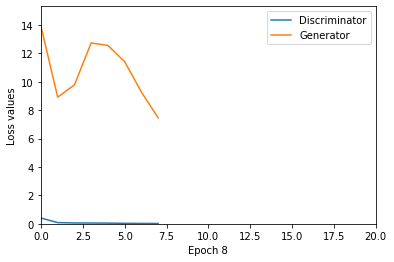

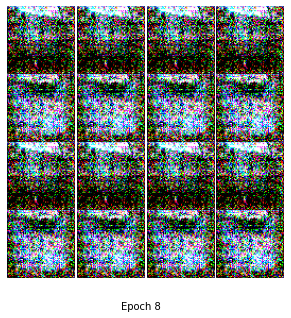

Epoch [9/20], Step [1/259], D_loss: 0.0009, G_loss: 7.5517
Epoch [9/20], Step [2/259], D_loss: 0.0007, G_loss: 6.2149
Epoch [9/20], Step [3/259], D_loss: 0.0020, G_loss: 7.2703
Epoch [9/20], Step [4/259], D_loss: 0.0008, G_loss: 7.9899
Epoch [9/20], Step [5/259], D_loss: 0.0010, G_loss: 6.9387
Epoch [9/20], Step [6/259], D_loss: 0.0020, G_loss: 7.5067
Epoch [9/20], Step [7/259], D_loss: 0.0008, G_loss: 7.5108
Epoch [9/20], Step [8/259], D_loss: 0.0052, G_loss: 7.5210
Epoch [9/20], Step [9/259], D_loss: 0.0007, G_loss: 7.7781
Epoch [9/20], Step [10/259], D_loss: 0.0008, G_loss: 7.6636
Epoch [9/20], Step [11/259], D_loss: 0.0007, G_loss: 7.2328
Epoch [9/20], Step [12/259], D_loss: 0.0008, G_loss: 6.8839
Epoch [9/20], Step [13/259], D_loss: 0.0006, G_loss: 7.2391
Epoch [9/20], Step [14/259], D_loss: 0.0013, G_loss: 8.0752
Epoch [9/20], Step [15/259], D_loss: 0.0006, G_loss: 6.8938
Epoch [9/20], Step [16/259], D_loss: 0.0007, G_loss: 5.5628
Epoch [9/20], Step [17/259], D_loss: 0.0013, G_lo

Epoch [9/20], Step [138/259], D_loss: 0.0022, G_loss: 5.5069
Epoch [9/20], Step [139/259], D_loss: 0.0031, G_loss: 6.5123
Epoch [9/20], Step [140/259], D_loss: 0.0021, G_loss: 5.4194
Epoch [9/20], Step [141/259], D_loss: 0.0020, G_loss: 5.9429
Epoch [9/20], Step [142/259], D_loss: 0.0020, G_loss: 5.6508
Epoch [9/20], Step [143/259], D_loss: 0.0024, G_loss: 6.2338
Epoch [9/20], Step [144/259], D_loss: 0.0019, G_loss: 6.2424
Epoch [9/20], Step [145/259], D_loss: 0.0018, G_loss: 6.4157
Epoch [9/20], Step [146/259], D_loss: 0.0077, G_loss: 6.2689
Epoch [9/20], Step [147/259], D_loss: 0.0053, G_loss: 6.9302
Epoch [9/20], Step [148/259], D_loss: 0.0037, G_loss: 6.3893
Epoch [9/20], Step [149/259], D_loss: 0.0017, G_loss: 5.6393
Epoch [9/20], Step [150/259], D_loss: 0.0018, G_loss: 6.4920
Epoch [9/20], Step [151/259], D_loss: 0.0017, G_loss: 6.1581
Epoch [9/20], Step [152/259], D_loss: 0.0023, G_loss: 6.2581
Epoch [9/20], Step [153/259], D_loss: 0.0023, G_loss: 6.9963
Epoch [9/20], Step [154/

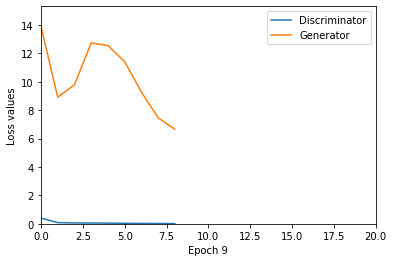

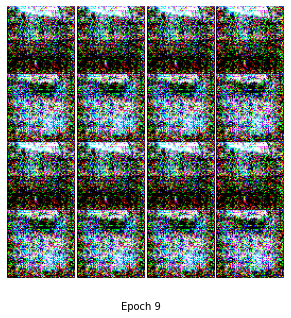

Epoch [10/20], Step [1/259], D_loss: 0.0008, G_loss: 7.5034
Epoch [10/20], Step [2/259], D_loss: 0.0010, G_loss: 7.3570
Epoch [10/20], Step [3/259], D_loss: 0.0008, G_loss: 7.5832
Epoch [10/20], Step [4/259], D_loss: 0.0008, G_loss: 6.7339
Epoch [10/20], Step [5/259], D_loss: 0.0008, G_loss: 8.0261
Epoch [10/20], Step [6/259], D_loss: 0.0008, G_loss: 7.2920
Epoch [10/20], Step [7/259], D_loss: 0.0012, G_loss: 6.5357
Epoch [10/20], Step [8/259], D_loss: 0.0011, G_loss: 7.1321
Epoch [10/20], Step [9/259], D_loss: 0.0008, G_loss: 7.6747
Epoch [10/20], Step [10/259], D_loss: 0.0007, G_loss: 7.2260
Epoch [10/20], Step [11/259], D_loss: 0.0009, G_loss: 7.0530
Epoch [10/20], Step [12/259], D_loss: 0.0007, G_loss: 7.8115
Epoch [10/20], Step [13/259], D_loss: 0.0008, G_loss: 7.2370
Epoch [10/20], Step [14/259], D_loss: 0.0008, G_loss: 7.3234
Epoch [10/20], Step [15/259], D_loss: 0.0008, G_loss: 6.9734
Epoch [10/20], Step [16/259], D_loss: 0.0016, G_loss: 7.2491
Epoch [10/20], Step [17/259], D_l

Epoch [10/20], Step [135/259], D_loss: 0.0034, G_loss: 5.2373
Epoch [10/20], Step [136/259], D_loss: 0.0022, G_loss: 5.9532
Epoch [10/20], Step [137/259], D_loss: 0.0029, G_loss: 5.3884
Epoch [10/20], Step [138/259], D_loss: 0.0020, G_loss: 5.6402
Epoch [10/20], Step [139/259], D_loss: 0.0023, G_loss: 5.8815
Epoch [10/20], Step [140/259], D_loss: 0.0019, G_loss: 6.1069
Epoch [10/20], Step [141/259], D_loss: 0.0019, G_loss: 6.0105
Epoch [10/20], Step [142/259], D_loss: 0.0018, G_loss: 6.3290
Epoch [10/20], Step [143/259], D_loss: 0.0070, G_loss: 5.9309
Epoch [10/20], Step [144/259], D_loss: 0.0018, G_loss: 5.4747
Epoch [10/20], Step [145/259], D_loss: 0.0019, G_loss: 6.3758
Epoch [10/20], Step [146/259], D_loss: 0.0019, G_loss: 6.9189
Epoch [10/20], Step [147/259], D_loss: 0.0055, G_loss: 5.6366
Epoch [10/20], Step [148/259], D_loss: 0.0018, G_loss: 6.5149
Epoch [10/20], Step [149/259], D_loss: 0.0017, G_loss: 6.3288
Epoch [10/20], Step [150/259], D_loss: 0.0016, G_loss: 7.0440
Epoch [1

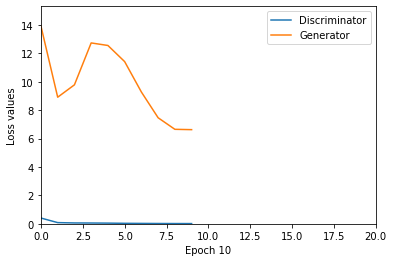

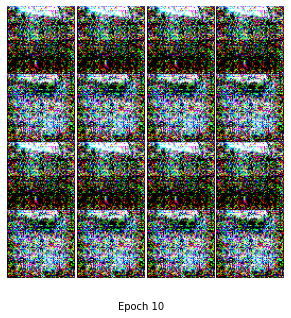

Epoch [11/20], Step [1/259], D_loss: 0.0007, G_loss: 7.7688
Epoch [11/20], Step [2/259], D_loss: 0.0007, G_loss: 7.8405
Epoch [11/20], Step [3/259], D_loss: 0.0007, G_loss: 6.2228
Epoch [11/20], Step [4/259], D_loss: 0.0009, G_loss: 7.1476
Epoch [11/20], Step [5/259], D_loss: 0.0013, G_loss: 6.8251
Epoch [11/20], Step [6/259], D_loss: 0.0009, G_loss: 8.2187
Epoch [11/20], Step [7/259], D_loss: 0.0007, G_loss: 7.4397
Epoch [11/20], Step [8/259], D_loss: 0.0013, G_loss: 7.4402
Epoch [11/20], Step [9/259], D_loss: 0.0007, G_loss: 7.6154
Epoch [11/20], Step [10/259], D_loss: 0.0039, G_loss: 6.7145
Epoch [11/20], Step [11/259], D_loss: 0.0009, G_loss: 7.6173
Epoch [11/20], Step [12/259], D_loss: 0.0008, G_loss: 7.5327
Epoch [11/20], Step [13/259], D_loss: 0.0007, G_loss: 7.5333
Epoch [11/20], Step [14/259], D_loss: 0.0008, G_loss: 7.8469
Epoch [11/20], Step [15/259], D_loss: 0.0010, G_loss: 6.4805
Epoch [11/20], Step [16/259], D_loss: 0.0008, G_loss: 6.0996
Epoch [11/20], Step [17/259], D_l

Epoch [11/20], Step [135/259], D_loss: 0.0015, G_loss: 7.5665
Epoch [11/20], Step [136/259], D_loss: 0.0014, G_loss: 7.7084
Epoch [11/20], Step [137/259], D_loss: 0.0009, G_loss: 7.2303
Epoch [11/20], Step [138/259], D_loss: 0.0055, G_loss: 7.4097
Epoch [11/20], Step [139/259], D_loss: 0.0068, G_loss: 6.9402
Epoch [11/20], Step [140/259], D_loss: 0.0012, G_loss: 7.1415
Epoch [11/20], Step [141/259], D_loss: 0.0025, G_loss: 7.6474
Epoch [11/20], Step [142/259], D_loss: 0.0015, G_loss: 6.9442
Epoch [11/20], Step [143/259], D_loss: 0.0067, G_loss: 7.2404
Epoch [11/20], Step [144/259], D_loss: 0.0009, G_loss: 7.5788
Epoch [11/20], Step [145/259], D_loss: 0.0025, G_loss: 7.5027
Epoch [11/20], Step [146/259], D_loss: 0.0025, G_loss: 7.2443
Epoch [11/20], Step [147/259], D_loss: 0.0009, G_loss: 7.5047
Epoch [11/20], Step [148/259], D_loss: 0.0012, G_loss: 7.4235
Epoch [11/20], Step [149/259], D_loss: 0.0009, G_loss: 7.3376
Epoch [11/20], Step [150/259], D_loss: 0.0009, G_loss: 7.1530
Epoch [1

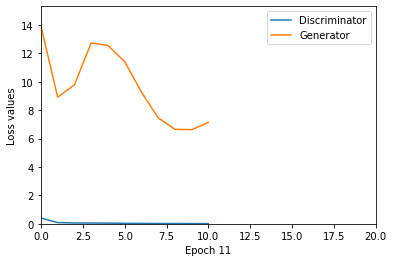

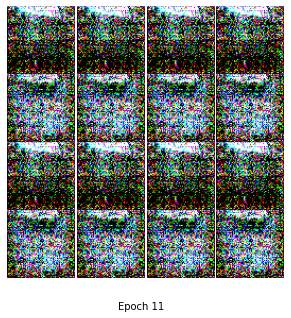

Epoch [12/20], Step [1/259], D_loss: 0.0011, G_loss: 6.8143
Epoch [12/20], Step [2/259], D_loss: 0.0011, G_loss: 6.9237
Epoch [12/20], Step [3/259], D_loss: 0.0185, G_loss: 7.2334
Epoch [12/20], Step [4/259], D_loss: 0.0011, G_loss: 6.3560
Epoch [12/20], Step [5/259], D_loss: 0.0008, G_loss: 6.2327
Epoch [12/20], Step [6/259], D_loss: 0.0009, G_loss: 7.0391
Epoch [12/20], Step [7/259], D_loss: 0.0009, G_loss: 6.3593
Epoch [12/20], Step [8/259], D_loss: 0.0009, G_loss: 6.8261
Epoch [12/20], Step [9/259], D_loss: 0.0009, G_loss: 7.1426
Epoch [12/20], Step [10/259], D_loss: 0.0016, G_loss: 7.5946
Epoch [12/20], Step [11/259], D_loss: 0.0014, G_loss: 7.3362
Epoch [12/20], Step [12/259], D_loss: 0.0008, G_loss: 7.6735
Epoch [12/20], Step [13/259], D_loss: 0.0009, G_loss: 6.9382
Epoch [12/20], Step [14/259], D_loss: 0.0008, G_loss: 7.3379
Epoch [12/20], Step [15/259], D_loss: 0.0012, G_loss: 7.2443
Epoch [12/20], Step [16/259], D_loss: 0.0010, G_loss: 8.0459
Epoch [12/20], Step [17/259], D_l

Epoch [12/20], Step [135/259], D_loss: 0.0012, G_loss: 6.9191
Epoch [12/20], Step [136/259], D_loss: 0.0012, G_loss: 7.2954
Epoch [12/20], Step [137/259], D_loss: 0.0011, G_loss: 6.9208
Epoch [12/20], Step [138/259], D_loss: 0.0014, G_loss: 7.4595
Epoch [12/20], Step [139/259], D_loss: 0.0010, G_loss: 6.3738
Epoch [12/20], Step [140/259], D_loss: 0.0014, G_loss: 6.6032
Epoch [12/20], Step [141/259], D_loss: 0.0014, G_loss: 7.1185
Epoch [12/20], Step [142/259], D_loss: 0.0017, G_loss: 6.1340
Epoch [12/20], Step [143/259], D_loss: 0.0010, G_loss: 7.7336
Epoch [12/20], Step [144/259], D_loss: 0.0020, G_loss: 7.1210
Epoch [12/20], Step [145/259], D_loss: 0.0012, G_loss: 6.8241
Epoch [12/20], Step [146/259], D_loss: 0.0072, G_loss: 7.0285
Epoch [12/20], Step [147/259], D_loss: 0.0010, G_loss: 7.1257
Epoch [12/20], Step [148/259], D_loss: 0.0011, G_loss: 6.7224
Epoch [12/20], Step [149/259], D_loss: 0.0017, G_loss: 7.3083
Epoch [12/20], Step [150/259], D_loss: 0.0012, G_loss: 5.6184
Epoch [1

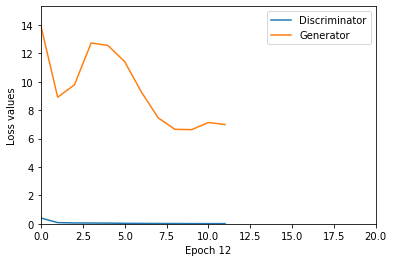

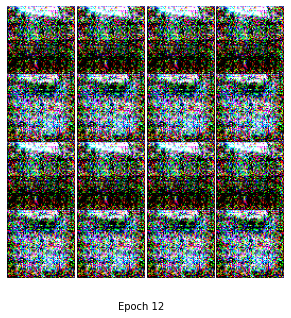

Epoch [13/20], Step [1/259], D_loss: 0.0009, G_loss: 6.9304
Epoch [13/20], Step [2/259], D_loss: 0.0010, G_loss: 7.4087
Epoch [13/20], Step [3/259], D_loss: 0.0010, G_loss: 7.5705
Epoch [13/20], Step [4/259], D_loss: 0.0014, G_loss: 7.4101
Epoch [13/20], Step [5/259], D_loss: 0.0014, G_loss: 7.4940
Epoch [13/20], Step [6/259], D_loss: 0.0010, G_loss: 6.4879
Epoch [13/20], Step [7/259], D_loss: 0.0009, G_loss: 5.2943
Epoch [13/20], Step [8/259], D_loss: 0.0010, G_loss: 7.7163
Epoch [13/20], Step [9/259], D_loss: 0.0009, G_loss: 6.9356
Epoch [13/20], Step [10/259], D_loss: 0.0011, G_loss: 7.5750
Epoch [13/20], Step [11/259], D_loss: 0.0009, G_loss: 7.7831
Epoch [13/20], Step [12/259], D_loss: 0.0010, G_loss: 6.4914
Epoch [13/20], Step [13/259], D_loss: 0.0012, G_loss: 6.6082
Epoch [13/20], Step [14/259], D_loss: 0.0011, G_loss: 7.0416
Epoch [13/20], Step [15/259], D_loss: 0.0009, G_loss: 7.9541
Epoch [13/20], Step [16/259], D_loss: 0.0011, G_loss: 6.1247
Epoch [13/20], Step [17/259], D_l

Epoch [13/20], Step [135/259], D_loss: 0.0013, G_loss: 6.5998
Epoch [13/20], Step [136/259], D_loss: 0.0013, G_loss: 7.0114
Epoch [13/20], Step [137/259], D_loss: 0.0012, G_loss: 7.0122
Epoch [13/20], Step [138/259], D_loss: 0.0012, G_loss: 7.6373
Epoch [13/20], Step [139/259], D_loss: 0.0014, G_loss: 6.3766
Epoch [13/20], Step [140/259], D_loss: 0.0030, G_loss: 7.0153
Epoch [13/20], Step [141/259], D_loss: 0.0012, G_loss: 6.7134
Epoch [13/20], Step [142/259], D_loss: 0.0013, G_loss: 6.2619
Epoch [13/20], Step [143/259], D_loss: 0.0012, G_loss: 7.4417
Epoch [13/20], Step [144/259], D_loss: 0.0012, G_loss: 7.7004
Epoch [13/20], Step [145/259], D_loss: 0.0012, G_loss: 6.6089
Epoch [13/20], Step [146/259], D_loss: 0.0012, G_loss: 6.6096
Epoch [13/20], Step [147/259], D_loss: 0.0012, G_loss: 6.6102
Epoch [13/20], Step [148/259], D_loss: 0.0022, G_loss: 7.0223
Epoch [13/20], Step [149/259], D_loss: 0.0012, G_loss: 7.7045
Epoch [13/20], Step [150/259], D_loss: 0.0014, G_loss: 7.1185
Epoch [1

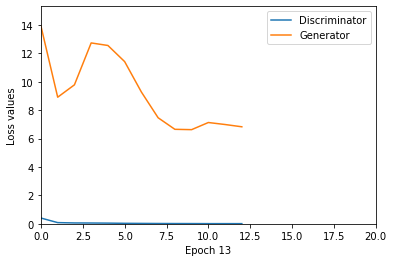

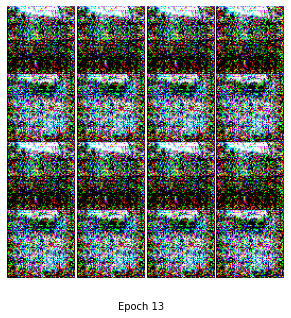

Epoch [14/20], Step [1/259], D_loss: 0.0011, G_loss: 6.7280
Epoch [14/20], Step [2/259], D_loss: 0.0012, G_loss: 7.6985
Epoch [14/20], Step [3/259], D_loss: 0.0014, G_loss: 7.1415
Epoch [14/20], Step [4/259], D_loss: 0.0020, G_loss: 6.8388
Epoch [14/20], Step [5/259], D_loss: 0.0013, G_loss: 7.2377
Epoch [14/20], Step [6/259], D_loss: 0.0010, G_loss: 6.8406
Epoch [14/20], Step [7/259], D_loss: 0.0013, G_loss: 7.4121
Epoch [14/20], Step [8/259], D_loss: 0.0010, G_loss: 7.1460
Epoch [14/20], Step [9/259], D_loss: 0.0011, G_loss: 7.9195
Epoch [14/20], Step [10/259], D_loss: 0.0011, G_loss: 7.0499
Epoch [14/20], Step [11/259], D_loss: 0.0019, G_loss: 7.4152
Epoch [14/20], Step [12/259], D_loss: 0.0013, G_loss: 7.1495
Epoch [14/20], Step [13/259], D_loss: 0.0015, G_loss: 5.1819
Epoch [14/20], Step [14/259], D_loss: 0.0039, G_loss: 7.0547
Epoch [14/20], Step [15/259], D_loss: 0.0010, G_loss: 6.2747
Epoch [14/20], Step [16/259], D_loss: 0.0015, G_loss: 6.8510
Epoch [14/20], Step [17/259], D_l

Epoch [14/20], Step [135/259], D_loss: 0.0013, G_loss: 7.0508
Epoch [14/20], Step [136/259], D_loss: 0.0014, G_loss: 5.5387
Epoch [14/20], Step [137/259], D_loss: 0.0027, G_loss: 5.6763
Epoch [14/20], Step [138/259], D_loss: 0.0080, G_loss: 6.6518
Epoch [14/20], Step [139/259], D_loss: 0.0065, G_loss: 5.8166
Epoch [14/20], Step [140/259], D_loss: 0.0014, G_loss: 6.7644
Epoch [14/20], Step [141/259], D_loss: 0.0013, G_loss: 6.9694
Epoch [14/20], Step [142/259], D_loss: 0.0013, G_loss: 5.9521
Epoch [14/20], Step [143/259], D_loss: 0.0017, G_loss: 6.6624
Epoch [14/20], Step [144/259], D_loss: 0.0026, G_loss: 7.2449
Epoch [14/20], Step [145/259], D_loss: 0.0018, G_loss: 5.9560
Epoch [14/20], Step [146/259], D_loss: 0.0023, G_loss: 6.6667
Epoch [14/20], Step [147/259], D_loss: 0.0016, G_loss: 6.6679
Epoch [14/20], Step [148/259], D_loss: 0.0013, G_loss: 7.1645
Epoch [14/20], Step [149/259], D_loss: 0.0018, G_loss: 7.0749
Epoch [14/20], Step [150/259], D_loss: 0.0015, G_loss: 6.5618
Epoch [1

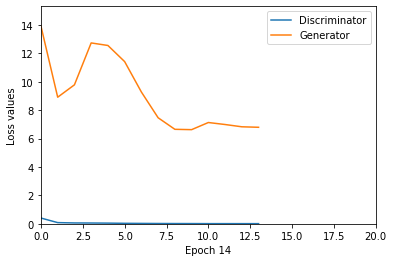

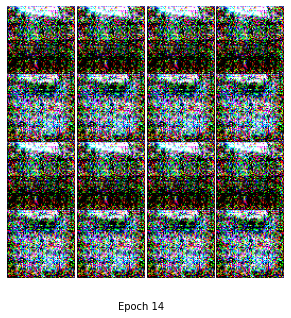

Epoch [15/20], Step [1/259], D_loss: 0.0011, G_loss: 5.6938
Epoch [15/20], Step [2/259], D_loss: 0.0011, G_loss: 6.5829
Epoch [15/20], Step [3/259], D_loss: 0.0011, G_loss: 7.0175
Epoch [15/20], Step [4/259], D_loss: 0.0011, G_loss: 7.3868
Epoch [15/20], Step [5/259], D_loss: 0.0014, G_loss: 7.0192
Epoch [15/20], Step [6/259], D_loss: 0.0012, G_loss: 6.2265
Epoch [15/20], Step [7/259], D_loss: 0.0014, G_loss: 6.4709
Epoch [15/20], Step [8/259], D_loss: 0.0016, G_loss: 7.1210
Epoch [15/20], Step [9/259], D_loss: 0.0012, G_loss: 6.8128
Epoch [15/20], Step [10/259], D_loss: 0.0011, G_loss: 5.4185
Epoch [15/20], Step [11/259], D_loss: 0.0012, G_loss: 6.5909
Epoch [15/20], Step [12/259], D_loss: 0.0011, G_loss: 7.2193
Epoch [15/20], Step [13/259], D_loss: 0.0017, G_loss: 5.9744
Epoch [15/20], Step [14/259], D_loss: 0.0011, G_loss: 7.4774
Epoch [15/20], Step [15/259], D_loss: 0.0011, G_loss: 7.3970
Epoch [15/20], Step [16/259], D_loss: 0.0011, G_loss: 6.9259
Epoch [15/20], Step [17/259], D_l

Epoch [15/20], Step [135/259], D_loss: 0.0015, G_loss: 7.5482
Epoch [15/20], Step [136/259], D_loss: 0.0016, G_loss: 6.2517
Epoch [15/20], Step [137/259], D_loss: 0.0018, G_loss: 6.7063
Epoch [15/20], Step [138/259], D_loss: 0.0015, G_loss: 6.4871
Epoch [15/20], Step [139/259], D_loss: 0.0014, G_loss: 4.8902
Epoch [15/20], Step [140/259], D_loss: 0.0018, G_loss: 6.7100
Epoch [15/20], Step [141/259], D_loss: 0.0015, G_loss: 6.6027
Epoch [15/20], Step [142/259], D_loss: 0.0014, G_loss: 7.5565
Epoch [15/20], Step [143/259], D_loss: 0.0014, G_loss: 6.2597
Epoch [15/20], Step [144/259], D_loss: 0.0014, G_loss: 7.6164
Epoch [15/20], Step [145/259], D_loss: 0.0022, G_loss: 6.7156
Epoch [15/20], Step [146/259], D_loss: 0.0014, G_loss: 6.1418
Epoch [15/20], Step [147/259], D_loss: 0.0014, G_loss: 7.3582
Epoch [15/20], Step [148/259], D_loss: 0.0016, G_loss: 6.7191
Epoch [15/20], Step [149/259], D_loss: 0.0015, G_loss: 6.1454
Epoch [15/20], Step [150/259], D_loss: 0.0018, G_loss: 7.5021
Epoch [1

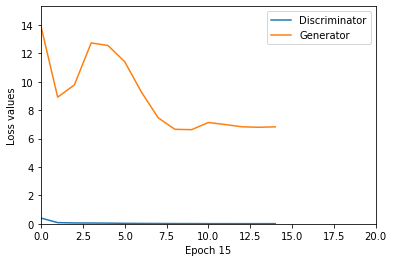

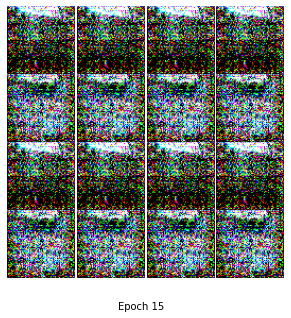

Epoch [16/20], Step [1/259], D_loss: 0.0021, G_loss: 6.4250
Epoch [16/20], Step [2/259], D_loss: 0.0024, G_loss: 5.6417
Epoch [16/20], Step [3/259], D_loss: 0.0028, G_loss: 6.7760
Epoch [16/20], Step [4/259], D_loss: 0.0011, G_loss: 6.9896
Epoch [16/20], Step [5/259], D_loss: 0.0013, G_loss: 7.4444
Epoch [16/20], Step [6/259], D_loss: 0.0016, G_loss: 5.9226
Epoch [16/20], Step [7/259], D_loss: 0.0049, G_loss: 6.8903
Epoch [16/20], Step [8/259], D_loss: 0.0012, G_loss: 6.8920
Epoch [16/20], Step [9/259], D_loss: 0.0021, G_loss: 7.2833
Epoch [16/20], Step [10/259], D_loss: 0.0011, G_loss: 5.5129
Epoch [16/20], Step [11/259], D_loss: 0.0012, G_loss: 6.3195
Epoch [16/20], Step [12/259], D_loss: 0.0018, G_loss: 7.0018
Epoch [16/20], Step [13/259], D_loss: 0.0024, G_loss: 6.0672
Epoch [16/20], Step [14/259], D_loss: 0.0018, G_loss: 6.6804
Epoch [16/20], Step [15/259], D_loss: 0.0015, G_loss: 7.2914
Epoch [16/20], Step [16/259], D_loss: 0.0011, G_loss: 7.1067
Epoch [16/20], Step [17/259], D_l

Epoch [16/20], Step [135/259], D_loss: 0.0017, G_loss: 6.8632
Epoch [16/20], Step [136/259], D_loss: 0.0015, G_loss: 6.7628
Epoch [16/20], Step [137/259], D_loss: 0.0014, G_loss: 6.4344
Epoch [16/20], Step [138/259], D_loss: 0.0015, G_loss: 6.5495
Epoch [16/20], Step [139/259], D_loss: 0.0026, G_loss: 7.4507
Epoch [16/20], Step [140/259], D_loss: 0.0014, G_loss: 6.2002
Epoch [16/20], Step [141/259], D_loss: 0.0014, G_loss: 5.2613
Epoch [16/20], Step [142/259], D_loss: 0.0014, G_loss: 6.2026
Epoch [16/20], Step [143/259], D_loss: 0.0014, G_loss: 7.3872
Epoch [16/20], Step [144/259], D_loss: 0.0016, G_loss: 6.5575
Epoch [16/20], Step [145/259], D_loss: 0.0020, G_loss: 7.3171
Epoch [16/20], Step [146/259], D_loss: 0.0016, G_loss: 5.6898
Epoch [16/20], Step [147/259], D_loss: 0.0014, G_loss: 6.2091
Epoch [16/20], Step [148/259], D_loss: 0.0014, G_loss: 5.8269
Epoch [16/20], Step [149/259], D_loss: 0.0015, G_loss: 7.1602
Epoch [16/20], Step [150/259], D_loss: 0.0015, G_loss: 6.0882
Epoch [1

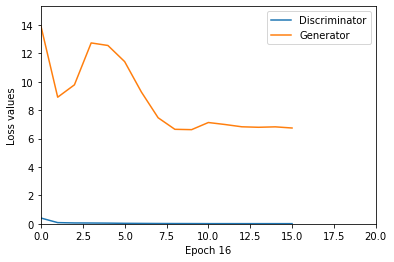

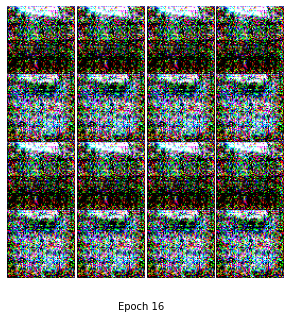

Epoch [17/20], Step [1/259], D_loss: 0.0014, G_loss: 6.9625
Epoch [17/20], Step [2/259], D_loss: 0.0025, G_loss: 6.0122
Epoch [17/20], Step [3/259], D_loss: 0.0013, G_loss: 6.8598
Epoch [17/20], Step [4/259], D_loss: 0.0015, G_loss: 7.4253
Epoch [17/20], Step [5/259], D_loss: 0.0011, G_loss: 7.6391
Epoch [17/20], Step [6/259], D_loss: 0.0012, G_loss: 6.6411
Epoch [17/20], Step [7/259], D_loss: 0.0013, G_loss: 6.9701
Epoch [17/20], Step [8/259], D_loss: 0.0014, G_loss: 5.4591
Epoch [17/20], Step [9/259], D_loss: 0.0095, G_loss: 7.5809
Epoch [17/20], Step [10/259], D_loss: 0.0015, G_loss: 7.7102
Epoch [17/20], Step [11/259], D_loss: 0.0011, G_loss: 7.0815
Epoch [17/20], Step [12/259], D_loss: 0.0042, G_loss: 6.9838
Epoch [17/20], Step [13/259], D_loss: 0.0011, G_loss: 6.6580
Epoch [17/20], Step [14/259], D_loss: 0.0021, G_loss: 6.8821
Epoch [17/20], Step [15/259], D_loss: 0.0018, G_loss: 7.3651
Epoch [17/20], Step [16/259], D_loss: 0.0061, G_loss: 7.7229
Epoch [17/20], Step [17/259], D_l

Epoch [17/20], Step [135/259], D_loss: 0.0017, G_loss: 6.6459
Epoch [17/20], Step [136/259], D_loss: 0.0036, G_loss: 6.4224
Epoch [17/20], Step [137/259], D_loss: 0.0024, G_loss: 7.6139
Epoch [17/20], Step [138/259], D_loss: 0.0017, G_loss: 7.0541
Epoch [17/20], Step [139/259], D_loss: 0.0023, G_loss: 5.6591
Epoch [17/20], Step [140/259], D_loss: 0.0015, G_loss: 7.1460
Epoch [17/20], Step [141/259], D_loss: 0.0015, G_loss: 5.3779
Epoch [17/20], Step [142/259], D_loss: 0.0019, G_loss: 6.5481
Epoch [17/20], Step [143/259], D_loss: 0.0019, G_loss: 6.6608
Epoch [17/20], Step [144/259], D_loss: 0.0014, G_loss: 6.7696
Epoch [17/20], Step [145/259], D_loss: 0.0016, G_loss: 6.3191
Epoch [17/20], Step [146/259], D_loss: 0.0014, G_loss: 6.6650
Epoch [17/20], Step [147/259], D_loss: 0.0015, G_loss: 6.9740
Epoch [17/20], Step [148/259], D_loss: 0.0015, G_loss: 5.8088
Epoch [17/20], Step [149/259], D_loss: 0.0026, G_loss: 6.9770
Epoch [17/20], Step [150/259], D_loss: 0.0035, G_loss: 6.8816
Epoch [1

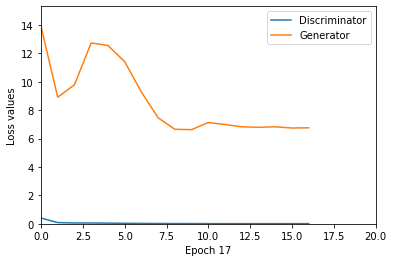

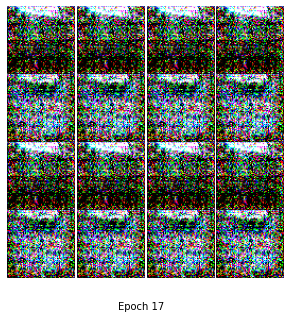

Epoch [18/20], Step [1/259], D_loss: 0.0025, G_loss: 6.7533
Epoch [18/20], Step [2/259], D_loss: 0.0019, G_loss: 6.9721
Epoch [18/20], Step [3/259], D_loss: 0.0012, G_loss: 7.1712
Epoch [18/20], Step [4/259], D_loss: 0.0019, G_loss: 7.0761
Epoch [18/20], Step [5/259], D_loss: 0.0014, G_loss: 6.4039
Epoch [18/20], Step [6/259], D_loss: 0.0014, G_loss: 7.1754
Epoch [18/20], Step [7/259], D_loss: 0.0012, G_loss: 7.0798
Epoch [18/20], Step [8/259], D_loss: 0.0013, G_loss: 7.3568
Epoch [18/20], Step [9/259], D_loss: 0.0012, G_loss: 7.6508
Epoch [18/20], Step [10/259], D_loss: 0.0019, G_loss: 7.2725
Epoch [18/20], Step [11/259], D_loss: 0.0012, G_loss: 7.6532
Epoch [18/20], Step [12/259], D_loss: 0.0011, G_loss: 6.1556
Epoch [18/20], Step [13/259], D_loss: 0.0019, G_loss: 5.7436
Epoch [18/20], Step [14/259], D_loss: 0.0017, G_loss: 7.3643
Epoch [18/20], Step [15/259], D_loss: 0.0012, G_loss: 6.4168
Epoch [18/20], Step [16/259], D_loss: 0.0011, G_loss: 6.4179
Epoch [18/20], Step [17/259], D_l

Epoch [18/20], Step [135/259], D_loss: 0.0015, G_loss: 6.9398
Epoch [18/20], Step [136/259], D_loss: 0.0015, G_loss: 6.4022
Epoch [18/20], Step [137/259], D_loss: 0.0019, G_loss: 6.5205
Epoch [18/20], Step [138/259], D_loss: 0.0027, G_loss: 4.5549
Epoch [18/20], Step [139/259], D_loss: 0.0018, G_loss: 6.9468
Epoch [18/20], Step [140/259], D_loss: 0.0021, G_loss: 5.6296
Epoch [18/20], Step [141/259], D_loss: 0.0015, G_loss: 5.4873
Epoch [18/20], Step [142/259], D_loss: 0.0015, G_loss: 7.0464
Epoch [18/20], Step [143/259], D_loss: 0.0024, G_loss: 6.8558
Epoch [18/20], Step [144/259], D_loss: 0.0016, G_loss: 7.2207
Epoch [18/20], Step [145/259], D_loss: 0.0021, G_loss: 6.6481
Epoch [18/20], Step [146/259], D_loss: 0.0014, G_loss: 7.3739
Epoch [18/20], Step [147/259], D_loss: 0.0027, G_loss: 5.4980
Epoch [18/20], Step [148/259], D_loss: 0.0018, G_loss: 6.7619
Epoch [18/20], Step [149/259], D_loss: 0.0015, G_loss: 7.1463
Epoch [18/20], Step [150/259], D_loss: 0.0015, G_loss: 6.4271
Epoch [1

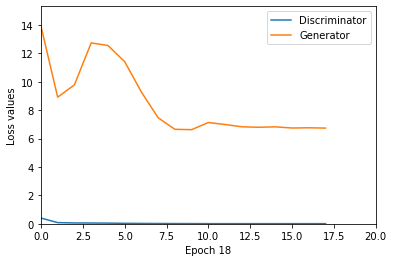

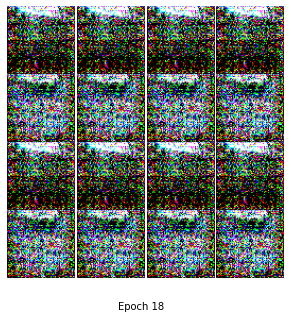

Epoch [19/20], Step [1/259], D_loss: 0.0011, G_loss: 6.7346
Epoch [19/20], Step [2/259], D_loss: 0.0012, G_loss: 6.6202
Epoch [19/20], Step [3/259], D_loss: 0.0011, G_loss: 7.3319
Epoch [19/20], Step [4/259], D_loss: 0.0011, G_loss: 7.4143
Epoch [19/20], Step [5/259], D_loss: 0.0011, G_loss: 7.0590
Epoch [19/20], Step [6/259], D_loss: 0.0019, G_loss: 5.9841
Epoch [19/20], Step [7/259], D_loss: 0.0022, G_loss: 6.8541
Epoch [19/20], Step [8/259], D_loss: 0.0017, G_loss: 5.0936
Epoch [19/20], Step [9/259], D_loss: 0.0011, G_loss: 5.9893
Epoch [19/20], Step [10/259], D_loss: 0.0011, G_loss: 6.6313
Epoch [19/20], Step [11/259], D_loss: 0.0013, G_loss: 6.6327
Epoch [19/20], Step [12/259], D_loss: 0.0011, G_loss: 7.3440
Epoch [19/20], Step [13/259], D_loss: 0.0017, G_loss: 7.6423
Epoch [19/20], Step [14/259], D_loss: 0.0012, G_loss: 6.6364
Epoch [19/20], Step [15/259], D_loss: 0.0011, G_loss: 6.8646
Epoch [19/20], Step [16/259], D_loss: 0.0011, G_loss: 6.7545
Epoch [19/20], Step [17/259], D_l

Epoch [19/20], Step [135/259], D_loss: 0.0024, G_loss: 6.0197
Epoch [19/20], Step [136/259], D_loss: 0.0045, G_loss: 7.0337
Epoch [19/20], Step [137/259], D_loss: 0.0014, G_loss: 6.5197
Epoch [19/20], Step [138/259], D_loss: 0.0024, G_loss: 5.3188
Epoch [19/20], Step [139/259], D_loss: 0.0064, G_loss: 6.4097
Epoch [19/20], Step [140/259], D_loss: 0.0016, G_loss: 6.4129
Epoch [19/20], Step [141/259], D_loss: 0.0096, G_loss: 6.5370
Epoch [19/20], Step [142/259], D_loss: 0.0016, G_loss: 6.6539
Epoch [19/20], Step [143/259], D_loss: 0.0014, G_loss: 6.7653
Epoch [19/20], Step [144/259], D_loss: 0.0014, G_loss: 7.1494
Epoch [19/20], Step [145/259], D_loss: 0.0027, G_loss: 5.7821
Epoch [19/20], Step [146/259], D_loss: 0.0014, G_loss: 5.4960
Epoch [19/20], Step [147/259], D_loss: 0.0015, G_loss: 6.5519
Epoch [19/20], Step [148/259], D_loss: 0.0019, G_loss: 6.1900
Epoch [19/20], Step [149/259], D_loss: 0.0014, G_loss: 5.6468
Epoch [19/20], Step [150/259], D_loss: 0.0017, G_loss: 6.4397
Epoch [1

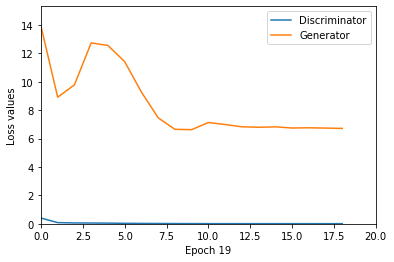

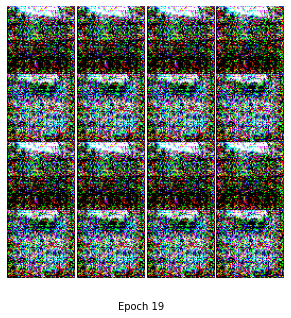

Epoch [20/20], Step [1/259], D_loss: 0.0017, G_loss: 5.5324
Epoch [20/20], Step [2/259], D_loss: 0.0011, G_loss: 6.3747
Epoch [20/20], Step [3/259], D_loss: 0.0011, G_loss: 6.7380
Epoch [20/20], Step [4/259], D_loss: 0.0012, G_loss: 6.6227
Epoch [20/20], Step [5/259], D_loss: 0.0019, G_loss: 7.8002
Epoch [20/20], Step [6/259], D_loss: 0.0011, G_loss: 5.8358
Epoch [20/20], Step [7/259], D_loss: 0.0011, G_loss: 6.8551
Epoch [20/20], Step [8/259], D_loss: 0.0011, G_loss: 6.7446
Epoch [20/20], Step [9/259], D_loss: 0.0011, G_loss: 7.0655
Epoch [20/20], Step [10/259], D_loss: 0.0013, G_loss: 7.1641
Epoch [20/20], Step [11/259], D_loss: 0.0012, G_loss: 7.8524
Epoch [20/20], Step [12/259], D_loss: 0.0015, G_loss: 5.2364
Epoch [20/20], Step [13/259], D_loss: 0.0011, G_loss: 7.0704
Epoch [20/20], Step [14/259], D_loss: 0.0011, G_loss: 6.5145
Epoch [20/20], Step [15/259], D_loss: 0.0011, G_loss: 7.0724
Epoch [20/20], Step [16/259], D_loss: 0.0015, G_loss: 7.1713
Epoch [20/20], Step [17/259], D_l

Epoch [20/20], Step [135/259], D_loss: 0.0022, G_loss: 7.4405
Epoch [20/20], Step [136/259], D_loss: 0.0028, G_loss: 6.8550
Epoch [20/20], Step [137/259], D_loss: 0.0032, G_loss: 7.1409
Epoch [20/20], Step [138/259], D_loss: 0.0016, G_loss: 6.8603
Epoch [20/20], Step [139/259], D_loss: 0.0016, G_loss: 4.8391
Epoch [20/20], Step [140/259], D_loss: 0.0015, G_loss: 6.4201
Epoch [20/20], Step [141/259], D_loss: 0.0021, G_loss: 6.7617
Epoch [20/20], Step [142/259], D_loss: 0.0015, G_loss: 6.4238
Epoch [20/20], Step [143/259], D_loss: 0.0015, G_loss: 6.7648
Epoch [20/20], Step [144/259], D_loss: 0.0014, G_loss: 5.9115
Epoch [20/20], Step [145/259], D_loss: 0.0014, G_loss: 7.0653
Epoch [20/20], Step [146/259], D_loss: 0.0014, G_loss: 6.6604
Epoch [20/20], Step [147/259], D_loss: 0.0015, G_loss: 6.6619
Epoch [20/20], Step [148/259], D_loss: 0.0014, G_loss: 6.4324
Epoch [20/20], Step [149/259], D_loss: 0.0024, G_loss: 6.5525
Epoch [20/20], Step [150/259], D_loss: 0.0027, G_loss: 5.4881
Epoch [2

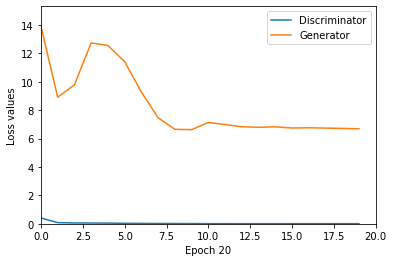

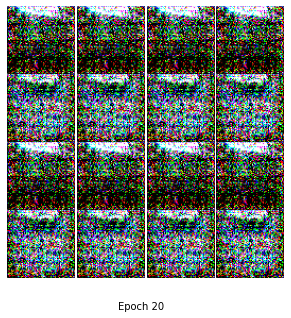

In [16]:
# Training GAN
D_avg_losses = []
G_avg_losses = []

step = 0
for epoch in range(num_epochs):
    D_losses = []
    G_losses = []

    if epoch == 5 or epoch == 10:
        G_optimizer.param_groups[0]['lr'] /= 10
        D_optimizer.param_groups[0]['lr'] /= 10

    # minibatch training
    for i, (images, _) in enumerate(data_loader):

        # image data
        mini_batch = images.size()[0]
        x_ = Variable(images.cuda())

        # labels
        y_real_ = Variable(torch.ones(mini_batch).cuda())
        y_fake_ = Variable(torch.zeros(mini_batch).cuda())
        c_label_ = label[mini_batch*i:mini_batch*(i+1)]
        c_fill_ = Variable(fill[c_label_].cuda())

        # Train discriminator with real data
        D_real_decision = D(x_, c_fill_).squeeze()
        D_real_loss = criterion(D_real_decision, y_real_)

        # Train discriminator with fake data
        z_ = torch.randn(mini_batch, G_input_dim).view(-1, G_input_dim, 1, 1)
        z_ = Variable(z_.cuda())

        c_ = (torch.rand(mini_batch, 1) * label_dim).type(torch.LongTensor).squeeze()
        c_onehot_ = Variable(onehot[c_].cuda())
        gen_image = G(z_, c_onehot_)

        c_fill_ = Variable(fill[c_].cuda())
        D_fake_decision = D(gen_image, c_fill_).squeeze()
        D_fake_loss = criterion(D_fake_decision, y_fake_)

        # Back propagation
        D_loss = D_real_loss + D_fake_loss
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Train generator
        z_ = torch.randn(mini_batch, G_input_dim).view(-1, G_input_dim, 1, 1)
        z_ = Variable(z_.cuda())

        c_ = (torch.rand(mini_batch, 1) * label_dim).type(torch.LongTensor).squeeze()
        c_onehot_ = Variable(onehot[c_].cuda())
        gen_image = G(z_, c_onehot_)

        c_fill_ = Variable(fill[c_].cuda())
        D_fake_decision = D(gen_image, c_fill_).squeeze()
        G_loss = criterion(D_fake_decision, y_real_)

        # Back propagation
        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # loss values
        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

        print('Epoch [%d/%d], Step [%d/%d], D_loss: %.4f, G_loss: %.4f'
              % (epoch+1, num_epochs, i+1, len(data_loader), D_loss.item(), G_loss.item()))

        # ============ TensorBoard logging ============#
        D_logger.scalar_summary('losses', D_loss.item(), step + 1)
        G_logger.scalar_summary('losses', G_loss.item(), step + 1)
        step += 1

    D_avg_loss = torch.mean(torch.FloatTensor(D_losses))
    G_avg_loss = torch.mean(torch.FloatTensor(G_losses))

    # avg loss values for plot
    D_avg_losses.append(D_avg_loss)
    G_avg_losses.append(G_avg_loss)

    plot_loss(D_avg_losses, G_avg_losses, epoch, save=True, save_dir=save_dir)

    # Show result for fixed noise
    plot_result(G, fixed_noise, fixed_label, epoch, save=True, save_dir=save_dir)

In [18]:
# Make gif
loss_plots = []
gen_image_plots = []
for epoch in range(num_epochs):
    # plot for generating gif
    save_fn1 = save_dir + 'cDCGAN_losses_epoch_{:d}'.format(epoch + 1) + '.png'
    loss_plots.append(imageio.imread(save_fn1))

    save_fn2 = save_dir + 'cDCGAN_epoch_{:d}'.format(epoch + 1) + '.png'
    gen_image_plots.append(imageio.imread(save_fn2))

imageio.mimsave(save_dir + 'cDCGAN_losses_epochs_{:d}'.format(num_epochs) + '.gif', loss_plots, fps=5)
imageio.mimsave(save_dir + 'cDCGAN_epochs_{:d}'.format(num_epochs) + '.gif', gen_image_plots, fps=5)

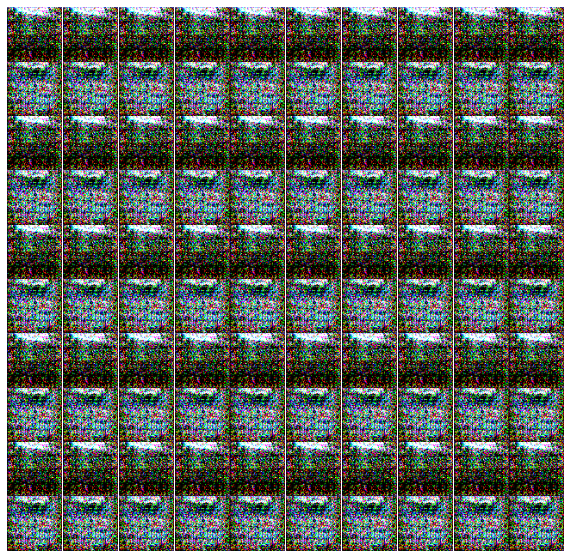

In [19]:
# plot noise morp result
plot_morp_result(G, save=True, save_dir=save_dir)